In [1]:
# Imports for handling and analysis of TIFF files
from Tesina_Tiff_and_Shapefile_Utils import (
    extract_pixels_within_mask,
    get_raster_info,
    reproject_tiff_files,
    copy_auxiliary_files
)

# Imports for processing shapefiles and manipulating pixel data
from Tesina_Tiff_and_Shapefile_Utils import (
    process_shapefile_data,
    analyze_masks_and_labels,
    enrich_metadata_with_pixel_data,
    reorder_and_select_specific_bands,
    normalize_pixels_globally_with_margin,
    realign_and_filter_pixel_data_by_bands
)

# Imports for recursively printing the structure and content of objects
from Tesina_General_Utils import print_recursive_structure_and_content, find_common_and_uncommon_elements


In [2]:
metadata_list = process_shapefile_data('data/output/labels', 'EPSG_3857')
analyze_masks_and_labels(metadata_list)
output_enriched = enrich_metadata_with_pixel_data(metadata_list)

Label occurrences:
Talado: 15 times
Quemado: 12 times
Nubes: 16 times
Bosque: 7 times

True values in masks by label:
Talado: 82230 True values
Quemado: 316263 True values
Nubes: 1541624 True values
Bosque: 552283 True values

False values in masks by label:
Talado: 2358273 False values
Quemado: 3259861 False values
Nubes: 1927211 False values
Bosque: 892500 False values


In [3]:
#print_recursive_structure_and_content(output_enriched[0])

In [4]:
selected_bands, uncommon_bands = find_common_and_uncommon_elements(output_enriched, "band_names")
print(f"Common bands: {selected_bands}")
print(f"Uncommon bands: {uncommon_bands}")
#remove "scl" from selected bands
selected_bands.remove("scl")
print(f"Selected bands: {selected_bands}")

Common bands: {'rededge2', 'rededge3', 'blue', 'nir08', 'nir', 'swir16', 'swir22', 'rededge1', 'red', 'scl', 'green', 'nir09'}
Uncommon bands: {'coastal'}
Selected bands: {'rededge2', 'rededge3', 'blue', 'nir08', 'nir', 'swir16', 'swir22', 'rededge1', 'red', 'green', 'nir09'}


In [5]:
output_enriched = realign_and_filter_pixel_data_by_bands(output_enriched, selected_bands)

In [6]:
output_normalized, min_global, max_global = normalize_pixels_globally_with_margin(output_enriched)
print(f"min_global: {min_global}")
print(f"max_global: {max_global}")

min_global: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
max_global: [17857.3 17683.8 16649.5 17466.4 17534.6 16781.9 16659.1 18132.3 18453.6
 17362.4 17132.4]


In [7]:
#print_recursive_structure_and_content(output_normalized[0])

In [8]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(output_data):
    # Initialize the LabelEncoder
    le = LabelEncoder()
    
    # Extract all labels and fit the LabelEncoder
    labels = [entry['label'] for entry in output_data]
    le.fit(labels)
    
    # Transform the labels and add them to the metadata
    for entry in output_data:
        entry['encoded_label'] = le.transform([entry['label']])[0]

    return output_data, le.classes_

# Now, the encode_labels function will add a new key 'encoded_label' to each entry in output_data.
output_normalized, label_classes = encode_labels(output_normalized)


In [9]:
print (label_classes)
print(output_normalized[5]['encoded_label'])
selected_bands = list(selected_bands)
print(selected_bands)

['Bosque' 'Nubes' 'Quemado' 'Talado']
2
['rededge2', 'rededge3', 'blue', 'nir08', 'nir', 'swir16', 'swir22', 'rededge1', 'red', 'green', 'nir09']


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
# Preparing the data
normalized_pixels = []
labels = []

for entry in output_normalized:
    for pixel_values in entry['pixels_normalized']:
        filtered_pixel = [pixel_values[selected_bands.index(band)] for band in selected_bands]
        normalized_pixels.append(filtered_pixel)
        labels.append(entry['encoded_label'])
   

# Convert to NumPy arrays
X_pixels_normalized = np.array(normalized_pixels)
y = np.array(labels)

# Splitting the data for training and testing
X_train_pixels, X_test_pixels, y_train, y_test = train_test_split(X_pixels_normalized, y, test_size=0.2, random_state=42)



#shape of the data
print(f"X_train_pixels: {X_train_pixels.shape}")
print(f"X_test_pixels: {X_test_pixels.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train_pixels: (1993920, 11)
X_test_pixels: (498480, 11)
y_train: (1993920,)
y_test: (498480,)


In [11]:
#Preparing the data for the model withouth clouds
cloud_label_encoded = 1

mask = y_train != cloud_label_encoded
X_train_pixels_no_clouds = X_train_pixels[mask]
y_train_no_clouds = y_train[mask]

mask_test = y_test != cloud_label_encoded
X_test_pixels_no_clouds = X_test_pixels[mask_test]
y_test_no_clouds = y_test[mask_test]

In [12]:
y_train_binary = np.where(y_train == cloud_label_encoded, 1, 0)
y_test_binary = np.where(y_test == cloud_label_encoded, 1, 0)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [14]:
rf_model = RandomForestClassifier(n_jobs=-1)
knn_model = KNeighborsClassifier()
rf_model.fit(X_train_pixels, y_train)
knn_model.fit(X_train_pixels, y_train)

KNeighborsClassifier()

In [15]:
from Tesina_Models_Utils import (save_model, save_model_metadata_and_analysis)

In [16]:
model_name ='random_forest_pixels_4_labels'
save_model(rf_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(rf_model, X_train_pixels, y_train, X_test_pixels, y_test, selected_bands, model_name, 'data/output/models/', print_info=True)

Model saved to: data/output/models/random_forest_pixels_4_labels_model.joblib
{'class_labels': [0, 1, 2, 3],
 'classification_report': {'0': {'f1-score': 0.9975269050983803,
                                 'precision': 0.996587988270644,
                                 'recall': 0.9984675927605092,
                                 'support': 110284},
                           '1': {'f1-score': 0.9994275233166673,
                                 'precision': 0.9996788133613642,
                                 'recall': 0.9991763595741714,
                                 'support': 308387},
                           '2': {'f1-score': 0.9959668189962035,
                                 'precision': 0.9948753528122487,
                                 'recall': 0.9970606826801517,
                                 'support': 63280},
                           '3': {'f1-score': 0.984421590701637,
                                 'precision': 0.9902062802228071,
                      

In [17]:
model_name ='knn_pixels_4_labels'
save_model(knn_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(knn_model, X_train_pixels, y_train, X_test_pixels, y_test, selected_bands, model_name, 'data/output/models/', print_info=True)

Model saved to: data/output/models/knn_pixels_4_labels_model.joblib
{'class_labels': [0, 1, 2, 3],
 'classification_report': {'0': {'f1-score': 0.9956146504165856,
                                 'precision': 0.9938380361224803,
                                 'recall': 0.9973976279424033,
                                 'support': 110284},
                           '1': {'f1-score': 0.9988516299393699,
                                 'precision': 0.9992535836099942,
                                 'recall': 0.9984499995135981,
                                 'support': 308387},
                           '2': {'f1-score': 0.9899363027160143,
                                 'precision': 0.9888981754529829,
                                 'recall': 0.9909766118836916,
                                 'support': 63280},
                           '3': {'f1-score': 0.9606443346146806,
                                 'precision': 0.9689211643793464,
                              

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Entrenar el modelo sin la etiqueta 'Nubes'
rf_model_no_clouds = RandomForestClassifier(n_jobs=-1)
rf_model_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)

In [45]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

def model_feature_importances(model, feature_names):
    # Obtener la importancia de las características del modelo
    feature_importances = model.feature_importances_

    # Ordenar las características por importancia
    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Graficar la importancia de las características
    plt.figure(figsize=(10, 6))
    plt.barh(features_df['Feature'], features_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # Para mostrar la característica más importante en la parte superior
    plt.show()
    
    print(features_df)

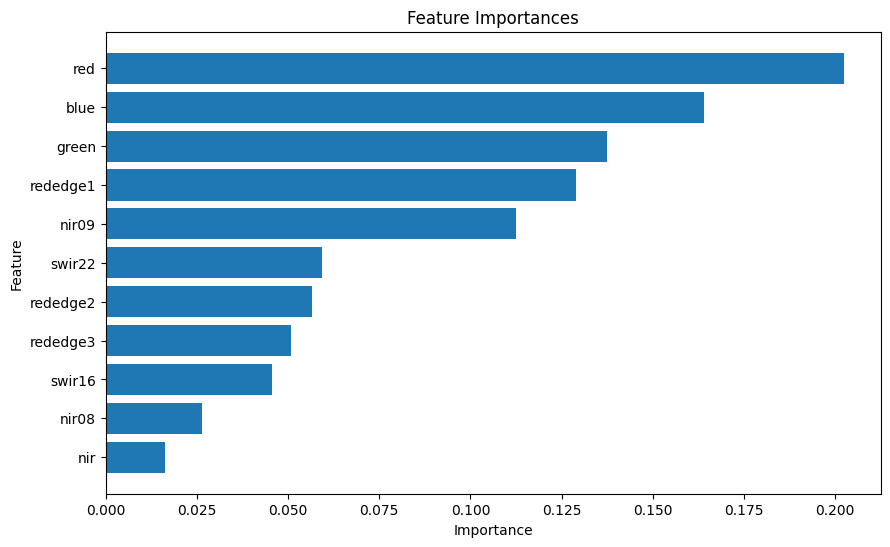

     Feature  Importance
3        red    0.202385
1       blue    0.163924
0      green    0.137353
2   rededge1    0.128850
7      nir09    0.112569
6     swir22    0.059158
5   rededge2    0.056676
9   rededge3    0.050882
10    swir16    0.045634
8      nir08    0.026440
4        nir    0.016130


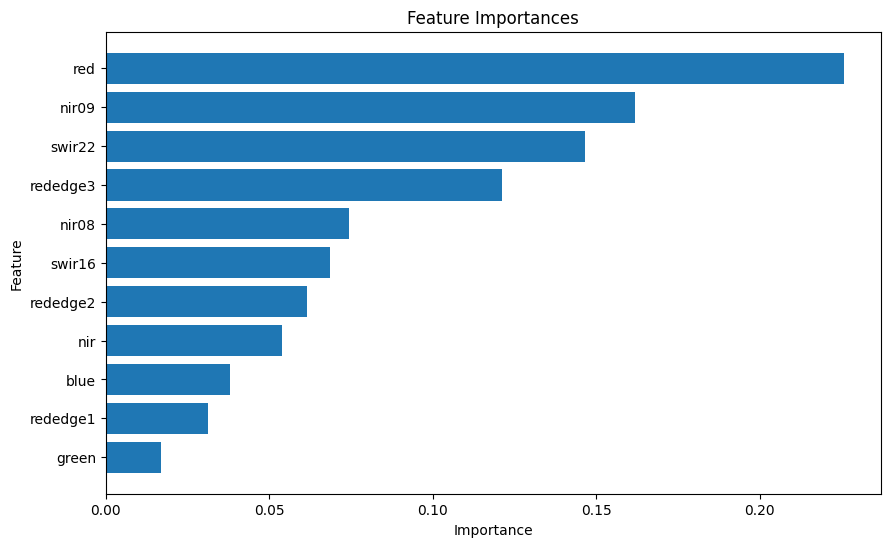

     Feature  Importance
3        red    0.225775
7      nir09    0.161745
6     swir22    0.146687
9   rededge3    0.121141
8      nir08    0.074291
10    swir16    0.068722
5   rededge2    0.061629
4        nir    0.053956
1       blue    0.037854
2   rededge1    0.031318
0      green    0.016882


In [ ]:
print("Características más importantes del modelo con nubes;")
model_feature_importances(rf_model, selected_bands)
print("Características más importantes del modelo sin nubes;")
model_feature_importances(rf_model_no_clouds, selected_bands)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pprint import pprint
# Suponiendo que X_train_pixels y y_train están definidos como los datos y etiquetas originales
# cloud_label_encoded = 1 representa las nubes en y_train

# Transformar y_train para tener dos categorías: 1 para nubes, 0 para no nubes
y_train_binary = np.where(y_train == cloud_label_encoded, 1, 0)
y_test_binary = np.where(y_test == cloud_label_encoded, 1, 0)

# Entrenar un modelo KNN con el conjunto binario
rf_model_binary = RandomForestClassifier(n_jobs=-1)
rf_model_binary.fit(X_train_pixels, y_train_binary)


RandomForestClassifier(n_jobs=-1)

In [ ]:
import time 
start_time = time.time()
y_pred_binary = rf_model_binary.predict(X_test_pixels)
end_time = time.time()
time_prediction_binary = end_time - start_time

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import time 

# Predicciones con el modelo original
start_time = time.time()
y_pred_original = rf_model.predict(X_test_pixels)
end_time = time.time()
time_prediction_original = end_time - start_time
# Transformar las predicciones del modelo original para clasificación binaria
y_pred_original_binary = np.where(y_pred_original == cloud_label_encoded, 1, 0)

In [ ]:
original_binary_report = classification_report(y_test_binary, y_pred_original_binary, digits=4)
original_binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_original_binary)

binary_report = classification_report(y_test_binary, y_pred_binary, digits=4)
binary_confusion_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print(f"Tiempo de predicción con el modelo original: {time_prediction_original}")
print(f"Tiempo de predicción con el modelo binario: {time_prediction_binary}")

Tiempo de predicción con el modelo original: 1.3074569702148438
Tiempo de predicción con el modelo binario: 0.8917684555053711


In [ ]:
print("Reporte de clasificación con el modelo original:")
print(original_binary_report)
print(original_binary_confusion_matrix)
print("Reporte de clasificación con el modelo binario:")
print(binary_report)
print(binary_confusion_matrix)

Reporte de clasificación con el modelo original:
              precision    recall  f1-score   support

           0     0.9986    0.9995    0.9990    189867
           1     0.9997    0.9991    0.9994    308613

    accuracy                         0.9993    498480
   macro avg     0.9991    0.9993    0.9992    498480
weighted avg     0.9993    0.9993    0.9993    498480

[[189766    101]
 [   266 308347]]
Reporte de clasificación con el modelo binario:
              precision    recall  f1-score   support

           0     0.9983    0.9997    0.9990    189867
           1     0.9998    0.9989    0.9994    308613

    accuracy                         0.9992    498480
   macro avg     0.9990    0.9993    0.9992    498480
weighted avg     0.9992    0.9992    0.9992    498480

[[189812     55]
 [   328 308285]]


Características más importantes del modelo original:


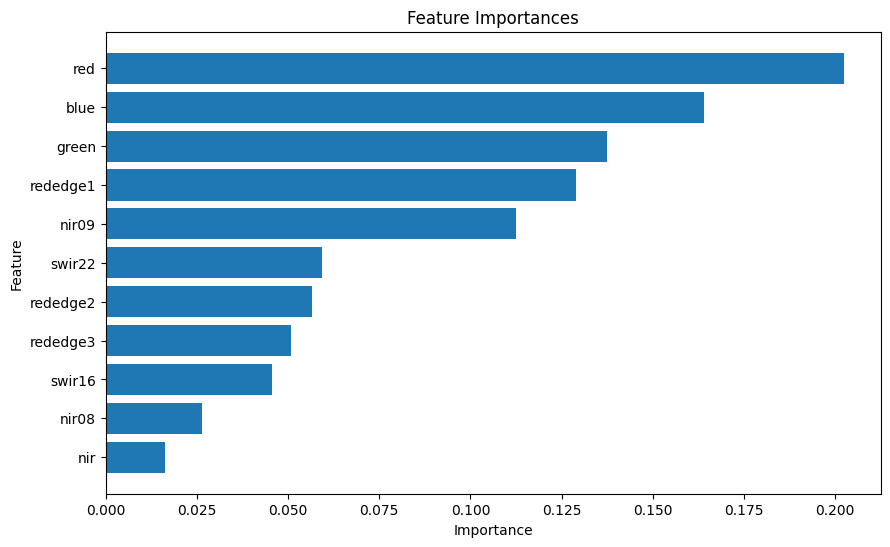

     Feature  Importance
3        red    0.202385
1       blue    0.163924
0      green    0.137353
2   rededge1    0.128850
7      nir09    0.112569
6     swir22    0.059158
5   rededge2    0.056676
9   rededge3    0.050882
10    swir16    0.045634
8      nir08    0.026440
4        nir    0.016130
Características más importantes del modelo binario:


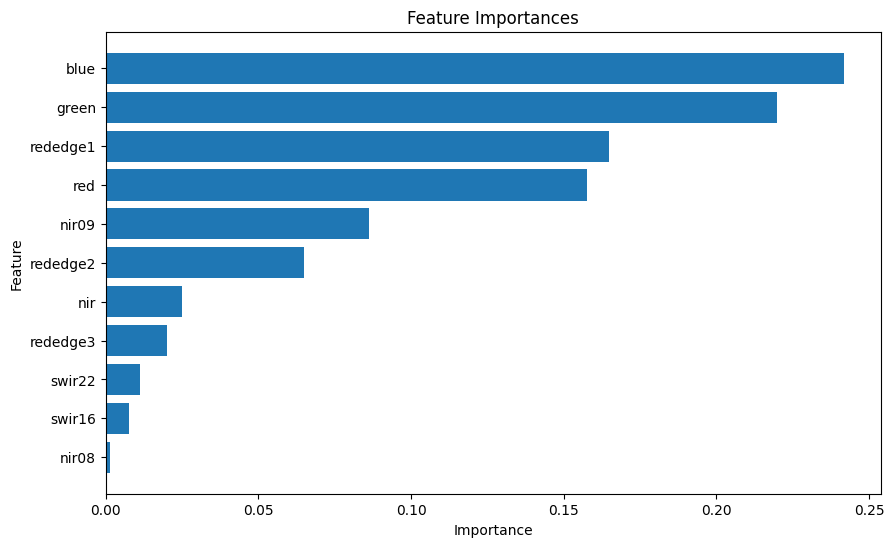

     Feature  Importance
1       blue    0.241789
0      green    0.219782
2   rededge1    0.164966
3        red    0.157583
7      nir09    0.086198
5   rededge2    0.064909
4        nir    0.025055
9   rededge3    0.019925
6     swir22    0.011090
10    swir16    0.007452
8      nir08    0.001251


In [ ]:
print("Características más importantes del modelo original:")
model_feature_importances(rf_model, selected_bands)
print("Características más importantes del modelo binario:")
model_feature_importances(rf_model_binary, selected_bands)

In [ ]:
import re


def extract_metrics(report, class_name):
    lines = report.split('\n')
    print(lines)
    for line in lines:
        if line.startswith(class_name):
            print(line)
            metrics_line = line.split()
            print(metrics_line)
            return {
                'Precision': float(metrics_line[1]),
                'Recall': float(metrics_line[2]),
                'F1': float(metrics_line[3])
            }
    return None

def extract_metrics_regex(report, class_name):
    # Crear una expresión regular que coincida con la línea de métricas para la clase deseada
    # El patrón busca un número seguido de tres valores flotantes (precisión, recall y F1)
    pattern = r'{}\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)'.format(class_name)
    
    # Buscar la línea que coincide con el patrón
    match = re.search(pattern, report)
    if match:
        return {
            'Precision': float(match.group(1)),
            'Recall': float(match.group(2)),
            'F1-Score': float(match.group(3))
        }
    return None


# Extracción de métricas para la clase 'Nubes' (índice 1) y 'No Nubes' (índice 0)
original_nubes_metrics = extract_metrics_regex(original_binary_report, '1')
original_no_nubes_metrics = extract_metrics_regex(original_binary_report, '0')

print(original_nubes_metrics)
print(original_no_nubes_metrics)

binary_nubes_metrics = extract_metrics_regex(binary_report, '1')
binary_no_nubes_metrics = extract_metrics_regex(binary_report, '0')
print(binary_nubes_metrics)
print(binary_no_nubes_metrics)

def extract_accuracy_with_regex(report):
    # Busca una línea que contenga la palabra "accuracy" seguida de uno o más espacios y un número
    match = re.search(r'accuracy\s+(\d+\.\d+)', report)
    if match:
        # Retorna la precisión (accuracy) como un float
        return float(match.group(1))
    else:
        return None

# Prueba de la función
accuracy_original = extract_accuracy_with_regex(original_binary_report)
accuracy_binary = extract_accuracy_with_regex(binary_report)

results = {
    'Modelo Original': {
        'Nubes': original_nubes_metrics,
        'No Nubes': original_no_nubes_metrics,
        'Accuracy': accuracy_original
    },
    'Modelo Binario': {
        'Nubes': binary_nubes_metrics,
        'No Nubes': binary_no_nubes_metrics,
        'Accuracy': accuracy_binary
    }
}

print(results)

{'Precision': 0.9997, 'Recall': 0.9991, 'F1-Score': 0.9994}
{'Precision': 0.9986, 'Recall': 0.9995, 'F1-Score': 0.999}
{'Precision': 0.9998, 'Recall': 0.9989, 'F1-Score': 0.9994}
{'Precision': 0.9983, 'Recall': 0.9997, 'F1-Score': 0.999}
{'Modelo Original': {'Nubes': {'Precision': 0.9997, 'Recall': 0.9991, 'F1-Score': 0.9994}, 'No Nubes': {'Precision': 0.9986, 'Recall': 0.9995, 'F1-Score': 0.999}, 'Accuracy': 0.9993}, 'Modelo Binario': {'Nubes': {'Precision': 0.9998, 'Recall': 0.9989, 'F1-Score': 0.9994}, 'No Nubes': {'Precision': 0.9983, 'Recall': 0.9997, 'F1-Score': 0.999}, 'Accuracy': 0.9992}}


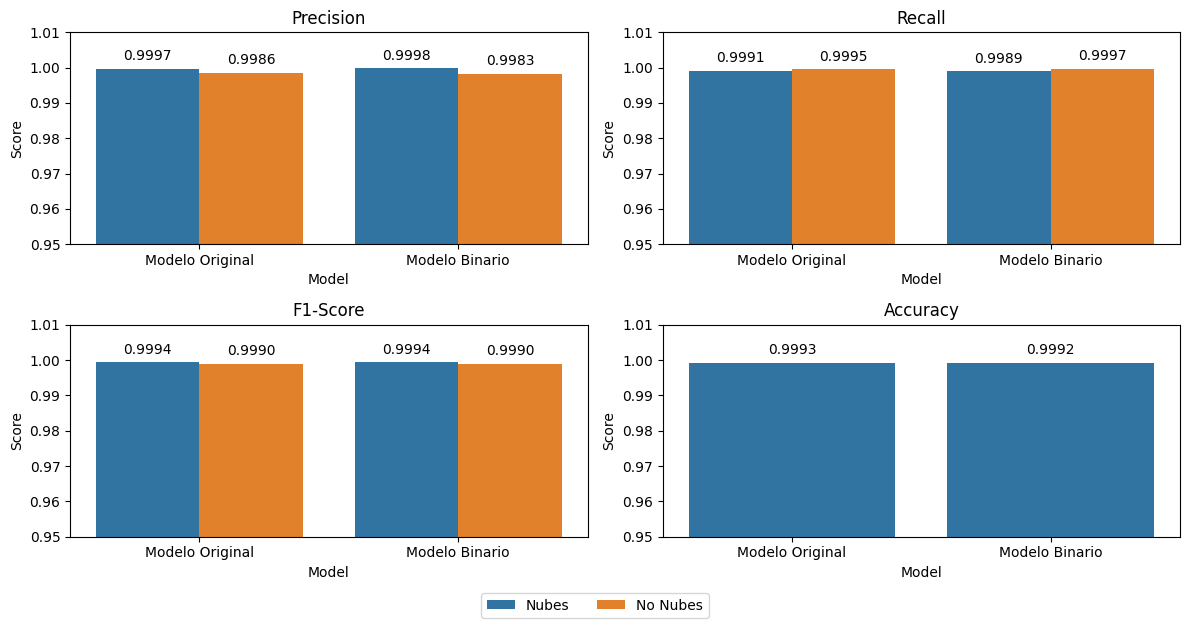

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(results):
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))  # Ajuste para un layout 2x2
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        data_to_plot = []
        for model in results:
            if metric == 'Accuracy':
                # Solo agregar datos de 'Accuracy' para el modelo, no para cada etiqueta
                data_to_plot.append({
                    'Model': model,
                    'Dataset': 'General', 
                    'Metric': metric,
                    'Score': results[model][metric]
                })
            else:
                for dataset in results[model]:
                    if dataset != 'Accuracy':  # Ignorar la métrica 'Accuracy' para este caso
                        data_to_plot.append({
                            'Model': model,
                            'Dataset': dataset,
                            'Metric': metric,
                            'Score': results[model][dataset][metric]
                        })
        sns_plot = sns.barplot(x='Model', y='Score', hue='Dataset', data=pd.DataFrame(data_to_plot), ax=axes[i])
        axes[i].set_title(metric)
        axes[i].set_ylim(0.95, 1.01)  # Ajustar los límites del eje Y para una mejor visualización
        # Desactivar la leyenda en los gráficos individuales
        sns_plot.get_legend().remove()
        # Añadir los puntajes en las barras
        for p in axes[i].patches:
            axes[i].annotate(format(p.get_height(), '.4f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center', 
                             xytext=(0, 9), 
                             textcoords='offset points')
            
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout()
    plt.show()
    
    
    

# Llamada a la función con tu diccionario 'results'
plot_results(results)


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Comparación entre modelos y generación del gráfico
def compare_models_and_plot(models, X_train, y_train):
    results = {}
    precisions = {}

    for model in models:
        model_name = type(model).__name__
        scores = cross_val_score(model, X_train, y_train, cv=5)
        results[model_name] = scores.mean()
        precisions[model_name] = scores 

    # Crear un DataFrame para el gráfico
    df = pd.DataFrame(precisions)

    # Crear un gráfico de caja
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df)
    plt.title('Distribución de la Precisión en la Validación Cruzada')
    plt.ylabel('Precisión')
    plt.show()

    return results

# Comparar modelos
models = [RandomForestClassifier(n_jobs=-1), KNeighborsClassifier()]
results = compare_models_and_plot(models, X_train_pixels, y_train)
print(results)



KeyError: 'RandomForestClassifier'

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Predict on the test set
y_pred_normal_model_no_clouds_data = rf_model.predict(X_test_pixels_no_clouds)


In [ ]:
cloud_label_encoded = 1

# Filtrar los datos
mask = y_train != cloud_label_encoded
X_train_pixels_no_clouds = X_train_pixels[mask]
y_train_no_clouds = y_train[mask]

# Entrenar el modelo sin la etiqueta 'Nubes'
rf_model_no_clouds = RandomForestClassifier(n_jobs=-1)
rf_model_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)

# Filtrar el conjunto de prueba y predecir
mask_test = y_test != cloud_label_encoded
X_test_pixels_no_clouds = X_test_pixels[mask_test]
y_test_no_clouds = y_test[mask_test]
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
conf_matrix_no_clouds = confusion_matrix(y_test[mask_test], y_pred_no_clouds)


In [ ]:
print("Reporte de Clasificación - Todas las Etiquetas:\n", classification_report(y_test_no_clouds, y_pred_normal_model_no_clouds_data, digits=4))
print("Reporte de Clasificación - Sin Nubes:\n", classification_report(y_test_no_clouds, y_pred_no_clouds, digits=4))

from sklearn.metrics import accuracy_score

# Exactitud para el modelo con todas las etiquetas (rf_model_all)
accuracy_model_all = accuracy_score(y_test, rf_model.predict(X_test_pixels))

# Exactitud para el modelo sin 'Nubes' (rf_model_no_clouds)
# Asegúrate de usar el conjunto de prueba ajustado que excluye 'Nubes'
accuracy_model_no_clouds = accuracy_score(y_test_no_clouds, rf_model_no_clouds.predict(X_test_pixels_no_clouds))

print(f"Exactitud del modelo con todas las etiquetas: {accuracy_model_all}")
print(f"Exactitud del modelo sin 'Nubes': {accuracy_model_no_clouds}")


/home/jvl/tesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jvl/tesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jvl/tesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Reporte de Clasificación - Todas las Etiquetas:
               precision    recall  f1-score   support

           0     0.9983    0.9986    0.9985    110075
           1     0.0000    0.0000    0.0000         0
           2     0.9952    0.9972    0.9962     63349
           3     0.9918    0.9765    0.9841     16443

    accuracy                         0.9962    189867
   macro avg     0.7463    0.7431    0.7447    189867
weighted avg     0.9967    0.9962    0.9964    189867

Reporte de Clasificación - Sin Nubes:
               precision    recall  f1-score   support

           0     0.9982    0.9991    0.9987    110075
           2     0.9951    0.9973    0.9962     63349
           3     0.9917    0.9774    0.9845     16443

    accuracy                         0.9966    189867
   macro avg     0.9950    0.9913    0.9931    189867
weighted avg     0.9966    0.9966    0.9966    189867

Exactitud del modelo con todas las etiquetas: 0.9980159685443749
Exactitud del modelo sin 'Nubes

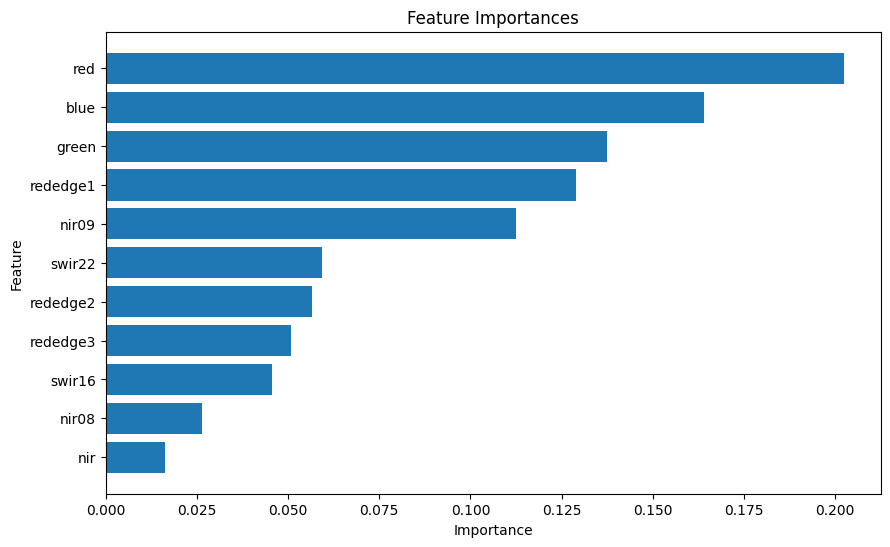

     Feature  Importance
3        red    0.202385
1       blue    0.163924
0      green    0.137353
2   rededge1    0.128850
7      nir09    0.112569
6     swir22    0.059158
5   rededge2    0.056676
9   rededge3    0.050882
10    swir16    0.045634
8      nir08    0.026440
4        nir    0.016130


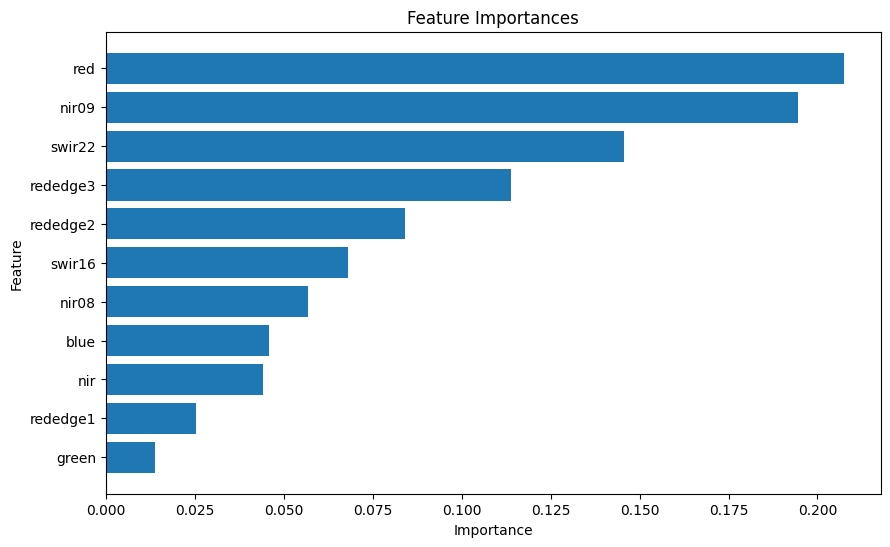

     Feature  Importance
3        red    0.207417
7      nir09    0.194642
6     swir22    0.145719
9   rededge3    0.113979
5   rededge2    0.084197
10    swir16    0.068045
8      nir08    0.056748
1       blue    0.045900
4        nir    0.044197
2   rededge1    0.025392
0      green    0.013762


In [ ]:
#Comparacion caracteristicas principales
model_feature_importances(rf_model, selected_bands)
model_feature_importances(rf_model_no_clouds, selected_bands)


In [ ]:
#Time comparation
import time
start_time = time.time()
y_pred_all = rf_model.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_prediction_all = end_time - start_time

start_time = time.time()
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_prediction_no_clouds = end_time - start_time


#dates in each model
print(f"Tiempo de predicción con el modelo con todas las etiquetas: {time_prediction_all}")
print(f"Tiempo de predicción con el modelo sin 'Nubes': {time_prediction_no_clouds}")


Tiempo de predicción con el modelo con todas las etiquetas: 0.5357620716094971
Tiempo de predicción con el modelo sin 'Nubes': 0.4454915523529053


In [15]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split

# Asumiendo que X_train_pixels y y_train_binary son tus datos y etiquetas originales
# Reducir el conjunto de datos al 20%
X_sample, _, y_sample, _ = train_test_split(X_train_pixels, y_train_binary, test_size=0.6, random_state=42)

# Configurar el modelo
rf_model_binary_default = RandomForestClassifier(n_jobs=6)
rf_model_binary_default.fit(X_train_pixels, y_train_binary)
print("Hiperparámetros por defecto:")
default_params = rf_model_binary_default.get_params()

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
}

rf_model_binary_best = RandomForestClassifier(n_jobs=6)
# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model_binary_best, param_distributions=param_dist, 
                                   n_iter=20, cv=3, n_jobs=6, verbose=2, random_state=42)

# Ajustar el modelo con el conjunto de datos reducido
random_search.fit(X_sample, y_sample)
rf_model_binary_best = random_search.best_estimator_
rf_model_binary_best.fit(X_train_pixels, y_train_binary)

print("Hiperparámetros por defecto:")
print(default_params)

# Mostrar los mejores hiperparámetros
print("\nMejores hiperparámetros recomendados:")
print(random_search.best_params_)

Hiperparámetros por defecto:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.5min
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.5min
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.5min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.5min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 2.5min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.6min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  49.6s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  49.2s
[CV] END criterion=entropy, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  51.1s
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.5min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.6min[CV] END criterion=entropy, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 2.6min



/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.7min
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 1.8min
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.7min
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.7min
[CV] END criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.8min
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END criterion=gini, max_depth=

/home/jvl/tesina/.tesina/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2.7min
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.6min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.7min
[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.7min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.3min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.4min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.4min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END criterion=gini, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.0min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.2min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.0min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.7min
[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.7min
[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 2.7min
[CV] END criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 2.6min
[CV] END criterion=entropy, max_de

/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.8min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 1.7min


/home/jvl/tesina/.tesina/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.4min
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.3min
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 1.5min
Hiperparámetros por defecto:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes'

In [26]:
from sklearn.metrics import classification_report
best_model = None
try:
    best_model = rf_model_binary_best
except NameError:
    best_model = RandomForestClassifier(n_jobs=6)
    best_model.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=30, criterion='entropy')
    best_model.fit(X_train_pixels, y_train_binary)

try:
    y_pred_default = rf_model_binary_default.predict(X_test_pixels)
    y_pred_best = best_model.predict(X_test_pixels)
    print("Hiperparámetros por defecto: ")
    print(default_params)
    print("Reporte de clasificación con hiperparámetros por defecto:")
    print(classification_report(y_test_binary, y_pred_default, digits=5))
except NameError:
    pass

try:
    best_params = random_search.best_params_
    print("Mejores hiperparámetros recomendados:")
    print(best_params)
    print("Reporte de clasificación con mejores hiperparámetros:")
    print(classification_report(y_test_binary, y_pred_best, digits=5))
except NameError:
    pass

import importlib
import Tesina_Models_Utils
importlib.reload(Tesina_Models_Utils)
from Tesina_Models_Utils import (save_model, save_model_metadata_and_analysis)

model_name ='random_forest_binary_best' 
binary_label_classes = ['No Nubes', 'Nubes']
save_model(best_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=binary_label_classes)
save_model_metadata_and_analysis(best_model, X_train_pixels, y_train_binary, X_test_pixels, y_test_binary, selected_bands, model_name, 'data/output/models/', print_info=True)

Mejores hiperparámetros recomendados:
Model saved to: data/output/models/random_forest_binary_best_model.joblib
{'class_labels': [0, 1],
 'classification_report': {'0': {'f1-score': 0.9990063666139183,
                                 'precision': 0.9983870035569987,
                                 'recall': 0.9996264986085758,
                                 'support': 190093},
                           '1': {'f1-score': 0.9993868991043537,
                                 'precision': 0.9997695934785219,
                                 'recall': 0.9990044975955537,
                                 'support': 308387},
                           'accuracy': 0.9992416947520463,
                           'macro avg': {'f1-score': 0.999196632859136,
                                         'precision': 0.9990782985177603,
                                         'recall': 0.9993154981020647,
                                         'support': 498480},
                           'weig

Características más importantes con mejores hiperparámetros:


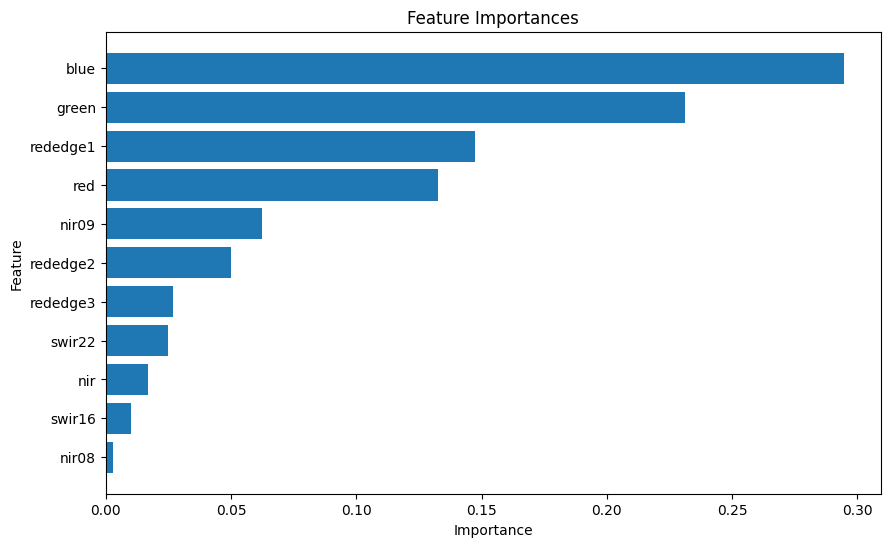

     Feature  Importance
9       blue    0.294622
1      green    0.231058
6   rededge1    0.147378
4        red    0.132720
2      nir09    0.062335
8   rededge2    0.049962
5   rededge3    0.027024
3     swir22    0.024981
0        nir    0.016740
10    swir16    0.010223
7      nir08    0.002957


In [46]:
print("Características más importantes con mejores hiperparámetros:")
model_feature_importances(rf_model_binary_best, selected_bands)    

In [17]:

from sklearn.model_selection import train_test_split

# Asumiendo que X_train_pixels y y_train_binary son tus datos y etiquetas originales
# Reducir el conjunto de datos al 20%
X_sample, _, y_sample, _ = train_test_split(X_train_pixels_no_clouds, y_train_no_clouds, test_size=0.6, random_state=42)

rf_default = RandomForestClassifier(n_jobs=-1) 
rf_default.fit(X_train_pixels_no_clouds, y_train_no_clouds)

default_params = rf_default.get_params()

# Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}
rf_best = RandomForestClassifier(n_jobs=-1)     
# Configurar RandomizedSearchCV
random_search_no_clouds = RandomizedSearchCV(estimator=rf_best, param_distributions=param_dist, 
                                   n_iter=20, cv=3, n_jobs=6, verbose=2, random_state=42)

# Ajustar el modelo con el conjunto de datos reducido
random_search.fit(X_sample, y_sample)
rf_best = random_search.best_estimator_
rf_best.fit(X_train_pixels_no_clouds, y_train_no_clouds)

#Mostrar hiperparametros por defecto
print("Hiperparámetros por defecto:")
print(default_params)

# Mostrar los mejores hiperparámetros
print("\nMejores hiperparámetros recomendados:")
print(random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  23.8s[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  24.0s

[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=  24.2s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  42.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  42.9s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=  44.0s
[CV] END criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10

/home/jvl/tesina/.tesina/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=entropy, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  57.2s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  57.4s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=  57.6s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  15.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.4s
[CV] END criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  21.8s
[CV] END criterion=gini, ma

In [27]:
import importlib
import Tesina_Models_Utils
importlib.reload(Tesina_Models_Utils)
from Tesina_Models_Utils import (save_model, save_model_metadata_and_analysis)

best_model = None
try:
    best_model = rf_best
except NameError:
    best_model = RandomForestClassifier(n_jobs=-1)
    best_model.set_params(n_estimators=200, min_samples_split=5, min_samples_leaf=1, max_features='sqrt', max_depth=30, criterion='entropy')
    best_model.fit(X_train_pixels_no_clouds, y_train_no_clouds)
    
y_pred_best = best_model.predict(X_test_pixels_no_clouds)

try:
    y_pred_default = rf_default.predict(X_test_pixels_no_clouds)
    print("Parametros por defecto:")
    print(rf_default.get_params())
    print("Reporte de clasificación con hiperparámetros por defecto:")
    print(classification_report(y_test_no_clouds, y_pred_default, digits=4))
except NameError:
    pass

try:
    best_params = random_search_no_clouds.best_params_
    print("Mejores hiperparámetros recomendados:")
    print(best_params)
    print("Reporte de clasificación con mejores hiperparámetros:")
    print(classification_report(y_test_no_clouds, y_pred_best, digits=4))
except NameError:
    pass

model_name ='random_forest_no_clouds_best'
no_cloud_label_classes = np.delete(label_classes, np.where(label_classes == 'Nubes'))
save_model(best_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=no_cloud_label_classes)
save_model_metadata_and_analysis(best_model, X_train_pixels_no_clouds, y_train_no_clouds, X_test_pixels_no_clouds, y_test_no_clouds, selected_bands, model_name, 'data/output/models/', print_info=True)


Model saved to: data/output/models/random_forest_no_clouds_best_model.joblib
{'class_labels': [0, 2, 3],
 'classification_report': {'0': {'f1-score': 0.9985951109862321,
                                 'precision': 0.9981879790530378,
                                 'recall': 0.9990025751695623,
                                 'support': 110284},
                           '2': {'f1-score': 0.996336764984526,
                                 'precision': 0.9955193739745046,
                                 'recall': 0.9971554993678887,
                                 'support': 63280},
                           '3': {'f1-score': 0.9845423563777993,
                                 'precision': 0.9903887358432812,
                                 'recall': 0.9787645955593199,
                                 'support': 16529},
                           'accuracy': 0.9966279663112266,
                           'macro avg': {'f1-score': 0.993158077449519,
                          

In [30]:
y_pred_default = rf_default.predict(X_test_pixels_no_clouds)
y_pred_best = rf_best.predict(X_test_pixels_no_clouds)

print("Parametros por defecto:")
print(rf_default.get_params())
print("Reporte de clasificación con hiperparámetros por defecto:")
print(classification_report(y_test_no_clouds, y_pred_default, digits=4))

print("Mejores hiperparámetros recomendados:")
print(rf_best.get_params())
print("Reporte de clasificación con mejores hiperparámetros:")
print(classification_report(y_test_no_clouds, y_pred_best, digits=4))

Parametros por defecto:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Reporte de clasificación con hiperparámetros por defecto:
              precision    recall  f1-score   support

           0     0.9982    0.9990    0.9986    110284
           2     0.9957    0.9972    0.9964     63280
           3     0.9905    0.9794    0.9849     16529

    accuracy                         0.9967    190093
   macro avg     0.9948    0.9919    0.9933    190093
weighted avg     0.9967    0.9967    0.9967    190093

Mejores hiperparámetros recomendados:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Asumiendo que X_train_pixels, y_train_binary, X_test_pixels y y_test_binary están definidos
# X_train_pixels y X_test_pixels son los píxeles de las imágenes
# y_train_binary y y_test_binary son las etiquetas binarias (nubes/no nubes)

# Entrenar el modelo XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)
xgb_model.fit(X_train_pixels, y_train_binary)

# Entrenar el modelo Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)
gb_model.fit(X_train_pixels, y_train_binary)

# Realizar predicciones con ambos modelos
y_pred_xgb = xgb_model.predict(X_test_pixels)
y_pred_gb = gb_model.predict(X_test_pixels)

# Evaluar los modelos
from sklearn.metrics import classification_report, accuracy_score

xgb_report = classification_report(y_test_binary, y_pred_xgb)
gb_report = classification_report(y_test_binary, y_pred_gb)

xgb_accuracy = accuracy_score(y_test_binary, y_pred_xgb)
gb_accuracy = accuracy_score(y_test_binary, y_pred_gb)

xgb_report, xgb_accuracy, gb_report, gb_accuracy

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
rf_model_default_no_clouds = RandomForestClassifier(n_jobs=-1)
rf_model_default_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)

rf_model_best_no_clouds = RandomForestClassifier(n_jobs=-1, n_estimators=300, min_samples_split=5, min_samples_leaf=2, max_depth=30)
rf_model_best_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)


In [ ]:
# Ajuste de hiperparámetros para el modelo sin nubes
grid_search_no_clouds = GridSearchCV(estimator=rf_model_no_clouds, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search_no_clouds.fit(X_train_pixels_no_clouds, y_train_no_clouds)

# Mejores hiperparámetros para el modelo sin nubes
print("Mejores hiperparámetros para el modelo sin nubes:", grid_search_no_clouds.best_params_)

In [ ]:
# Predicción con el modelo entrenado con todas las etiquetas
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)

# Matriz de confusión para el modelo entrenado con todas las etiquetas
conf_matrix_all_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_all_no_clouds)

# Matriz de confusión para el modelo entrenado sin 'Nubes'
conf_matrix_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_no_clouds)


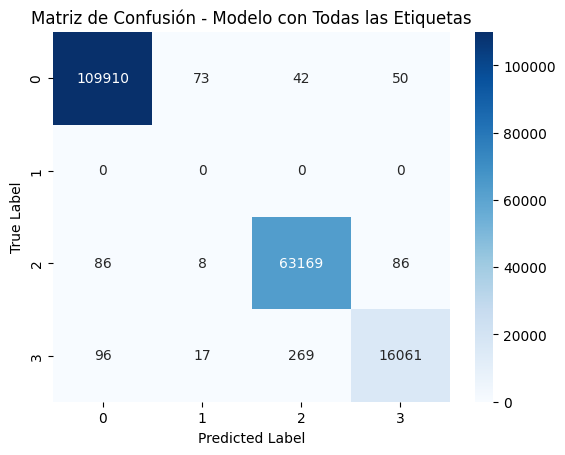

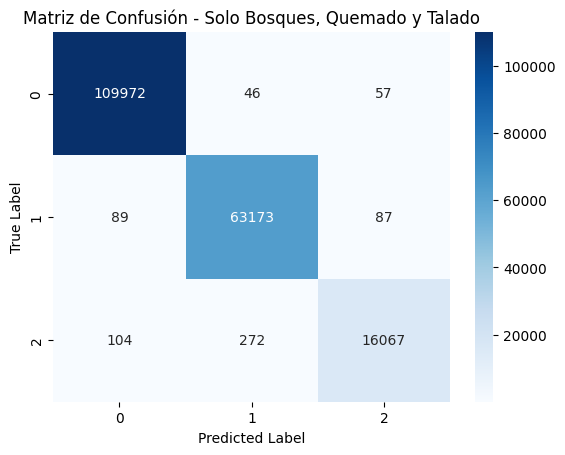

In [ ]:
# Matriz de Confusión - Modelo con Todas las Etiquetas
sns.heatmap(conf_matrix_all_no_clouds, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo con Todas las Etiquetas')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Matriz de Confusión - Modelo sin 'Nubes'
sns.heatmap(conf_matrix_no_clouds, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Solo Bosques, Quemado y Talado')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


/home/jvl/tesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Modelo con todas las etiquetas - Accuracy: 0.9961710039132656, Recall: 0.7431069623205729, F1: 0.7446706178188713
Modelo sin 'Nubes' - Accuracy: 0.9965502167306588, Recall: 0.9911397136007342, F1: 0.9929455996677695


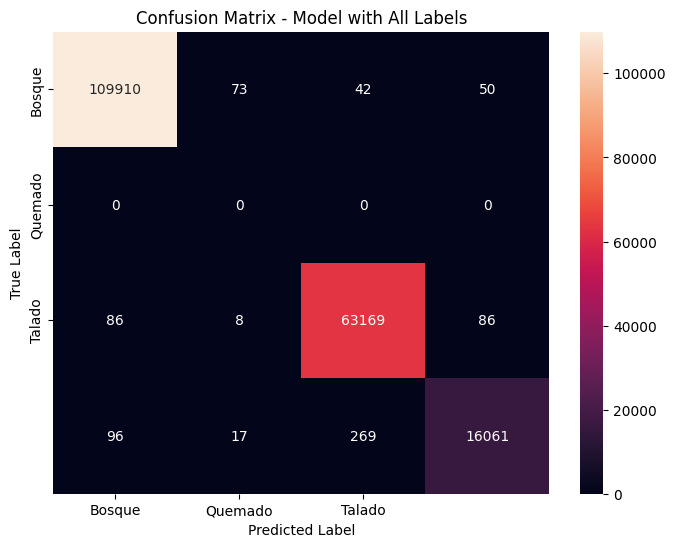

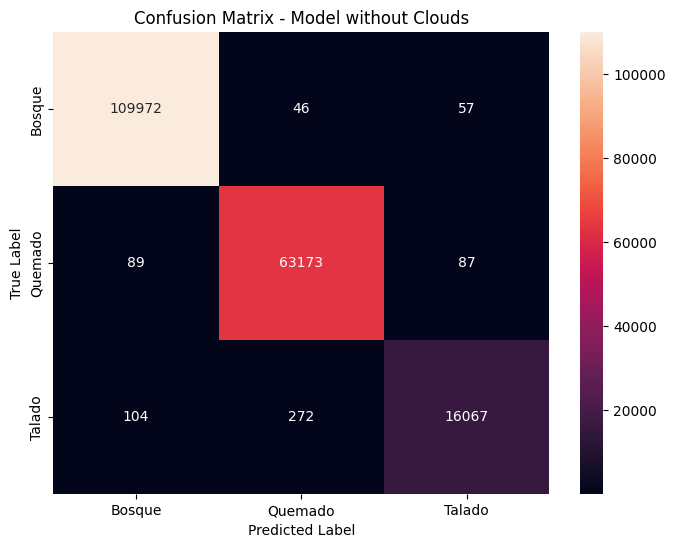

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluar el modelo entrenado con todas las etiquetas
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)
accuracy_all = accuracy_score(y_test_no_clouds, y_pred_all_no_clouds)
recall_all = recall_score(y_test_no_clouds, y_pred_all_no_clouds, average='macro')
f1_all = f1_score(y_test_no_clouds, y_pred_all_no_clouds, average='macro')

# Evaluar el modelo entrenado sin 'Nubes'
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
accuracy_no_clouds = accuracy_score(y_test_no_clouds, y_pred_no_clouds)
recall_no_clouds = recall_score(y_test_no_clouds, y_pred_no_clouds, average='macro')
f1_no_clouds = f1_score(y_test_no_clouds, y_pred_no_clouds, average='macro')

# Imprimir las métricas
print(f"Modelo con todas las etiquetas - Accuracy: {accuracy_all}, Recall: {recall_all}, F1: {f1_all}")
print(f"Modelo sin 'Nubes' - Accuracy: {accuracy_no_clouds}, Recall: {recall_no_clouds}, F1: {f1_no_clouds}")

# Matrices de confusión
adjusted_labels = [label for label in label_classes if label != 'Nubes']

# Matriz de Confusión - Modelo con Todas las Etiquetas
conf_matrix_all_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_all_no_clouds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_all_no_clouds, annot=True, fmt='d', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
plt.title('Confusion Matrix - Model with All Labels')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Matriz de Confusión - Modelo sin 'Nubes'
conf_matrix_no_clouds = confusion_matrix(y_test_no_clouds, y_pred_no_clouds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_no_clouds, annot=True, fmt='d', xticklabels=adjusted_labels, yticklabels=adjusted_labels)
plt.title('Confusion Matrix - Model without Clouds')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




In [ ]:
import time
# Tiempo de predicción para el modelo con todas las etiquetas
start_time = time.time()
y_pred_all_no_clouds = rf_model_all.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_pred_all = end_time - start_time
print(f"Tiempo de predicción (Modelo con todas las etiquetas): {time_pred_all} segundos")

# Tiempo de predicción para el modelo sin 'Nubes'
start_time = time.time()
y_pred_no_clouds = rf_model_no_clouds.predict(X_test_pixels_no_clouds)
end_time = time.time()
time_pred_no_clouds = end_time - start_time
print(f"Tiempo de predicción (Modelo sin 'Nubes'): {time_pred_no_clouds} segundos")


Tiempo de predicción (Modelo con todas las etiquetas): 0.47452616691589355 segundos
Tiempo de predicción (Modelo sin 'Nubes'): 0.3936636447906494 segundos


: 

In [ ]:
# Preparing data without clouds
normalized_pixels_non_cloud = []
indices_normalized_non_cloud = []
combined_pixels_indices_non_cloud = []
labels_non_cloud = []

for entry in non_cloud_data:
    for pixel_values in entry['pixels_normalized']:
        filtered_pixel = [pixel_values[selected_bands.index(band)] for band in selected_bands]
        normalized_pixels_non_cloud.append(filtered_pixel)
        labels_non_cloud.append(entry['encoded_label'])
    for index in entry['normalized_index']:
        indices_normalized_non_cloud.append(index)
    for pixel_values, index_values in zip(entry['pixels_normalized'], entry['normalized_index']):
        combined = [pixel_values[selected_bands.index(band)] for band in selected_bands] + index_values
        combined_pixels_indices_non_cloud.append(combined)

# Convert to NumPy arrays
X_pixels_normalized_non_cloud = np.array(normalized_pixels_non_cloud)
X_indices_normalized_non_cloud = np.array(indices_normalized_non_cloud)
X_combined_non_cloud = np.array(combined_pixels_indices_non_cloud)
y_non_cloud = np.array(labels_non_cloud)

# Splitting data for training and testing
X_train_pixels_nc, X_test_pixels_nc, y_train_nc, y_test_nc = train_test_split(X_pixels_normalized_non_cloud, y_non_cloud, test_size=0.2, random_state=42)
X_train_indices_nc, X_test_indices_nc, _, _ = train_test_split(X_indices_normalized_non_cloud, y_non_cloud, test_size=0.2, random_state=42)
X_train_combined_nc, X_test_combined_nc, _, _ = train_test_split(X_combined_non_cloud, y_non_cloud, test_size=0.2, random_state=42)


#shape of the data
print(f"X_train_pixels: {X_train_pixels_nc.shape}")
print(f"X_test_pixels: {X_test_pixels_nc.shape}")
print(f"X_train_indices: {X_train_indices_nc.shape}")
print(f"X_test_indices: {X_test_indices_nc.shape}")
print(f"X_train_combined: {X_train_combined_nc.shape}")
print(f"X_test_combined: {X_test_combined_nc.shape}")
print(f"y_train: {y_train_nc.shape}")
print(f"y_test: {y_test_nc.shape}")


RandomForestClassifier(n_jobs=-1)

In [ ]:
# Train and evaluate models on three data sets without clouds
results_non_cloud = {}

for model in models:
    model_name = type(model).__name__
    results_non_cloud[model_name] = {}  # Initialize a sub-dictionary for the model
    datasets_non_cloud = {
        "normalized_pixels": {
            "train": X_train_pixels_nc,
            "test": X_test_pixels_nc
        },
        "normalized_indices": {
            "train": X_train_indices_nc,
            "test": X_test_indices_nc
        },
        "combined": {
            "train": X_train_combined_nc,
            "test": X_test_combined_nc
        }
    }
    for dataset_name, dataset in datasets_non_cloud.items():
        report, accuracy = train_and_evaluate_model(dataset['train'], dataset['test'], y_train_nc, y_test_nc, model)
        results_non_cloud[model_name][dataset_name] = {
            'Precision': report['weighted avg']['precision'],
            'Recall': report['weighted avg']['recall'],
            'F1-Score': report['weighted avg']['f1-score'],
            'Overall Accuracy': accuracy
        }
        print(f"Model: {model_name}, Dataset: {dataset_name}, Accuracy: {accuracy}")


In [ ]:
# Compare results
print("Results with clouds included:")
plot_results(results)  # Using the plot_results function from before

print("Results without clouds:")
plot_results(results_non_cloud)


In [ ]:
model_name = 'random_forest'
save_model(rf_model, model_name, 'data/output/models/', min_vals=min_global, max_vals=max_global, label_classes=label_classes)
save_model_metadata_and_analysis(rf_model, X_train, y_train, X_test, y_test, x_names, model_name, 'data/output/models/', print_info=True)

Model saved to: data/output/models/random_forest_model.joblib
{'class_labels': [0, 1, 2, 3],
 'classification_report': {'0': {'f1-score': 0.9975813733987375,
                                 'precision': 0.9965729206331937,
                                 'recall': 0.9985918691801045,
                                 'support': 110075.0},
                           '1': {'f1-score': 0.9994263025686736,
                                 'precision': 0.9997114483670896,
                                 'recall': 0.9991413193870641,
                                 'support': 308613.0},
                           '2': {'f1-score': 0.9955947136563877,
                                 'precision': 0.9940671031096563,
                                 'recall': 0.9971270264723989,
                                 'support': 63349.0},
                           '3': {'f1-score': 0.9838867785810562,
                                 'precision': 0.9912351089438923,
                              

In [ ]:
from sklearn.feature_selection import SelectFromModel
feature_selector = SelectFromModel(rf_model, threshold=-np.inf, prefit=True)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
#Evaluar el modelo
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_classes))
print("Accuracy:", accuracy_score(y_test, y_pred))
feature_importance = rf_model.feature_importances_

if(len(selected_bands) == len(feature_importance)):
    feature_importance = [(selected_bands[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")
elif (len(index_names) == len(feature_importance)):
    feature_importance = [(index_names[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")
elif len(x_names) == len(feature_importance):
    feature_importance = [(x_names[i], importance) for i, importance in enumerate(feature_importance)]
    feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
    print("Características más importantes:")
    for feature, importance in feature_importance:
        print(f"{feature}: {importance}")

              precision    recall  f1-score   support

      Bosque       1.00      1.00      1.00    110075
       Nubes       1.00      1.00      1.00    308613
     Quemado       0.99      1.00      1.00     63349
      Talado       0.99      0.98      0.98     16443

    accuracy                           1.00    498480
   macro avg       1.00      0.99      0.99    498480
weighted avg       1.00      1.00      1.00    498480

Accuracy: 0.998052078318087
Características más importantes:
blue: 0.19346516579727446
red: 0.16845536716196285
green: 0.16343033771070578
nir09: 0.1267514015146926
rededge1: 0.08490453495899053
swir22: 0.07193643095197158
rededge2: 0.05923310593034659
rededge3: 0.04598637319173889
nir08: 0.035186241717828984
swir16: 0.03337263865702358
nir: 0.017278402407464036


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}



In [ ]:
rf = RandomForestClassifier()

# Utiliza RandomizedSearchCV para búsqueda aleatoria
random_search = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=6)

# O utiliza GridSearchCV para búsqueda exhaustiva
# grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# Ajusta el modelo a tus datos de entrenamiento
random_search.fit(X_train, y_train)

# Muestra los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.5s
[CV 3/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.7s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.9s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   1.9s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=nan total time=   2.0s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.992 total time=21.1min
[CV 2/5] END bootstrap

/home/jvl/tesis/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.997 total time=88.4min
[CV 1/5] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.997 total time=23.7min
[CV 3/5] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=0.997 total time=83.1min
[CV 1/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.2s
[CV 2/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.1s
[CV 3/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=nan total time=   0.1s
[CV 4/5] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4

: 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Supongamos que tienes tus etiquetas reales en y_test y las predicciones en y_pred
confusion_mat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])

# Utiliza seaborn para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

    

In [ ]:
from sklearn.model_selection import GridSearchCV

# Entrenar Regresión Logística
log_reg_model = LogisticRegression(max_iter=100000)
best_params = {'C': 10.0, 'fit_intercept': True, 'penalty': 'l2'}
log_reg_model_best = LogisticRegression(**best_params)
log_reg_model.fit(X_train, y_train)
log_reg_model_best.fit(X_train, y_train)


In [ ]:

# Definir la cuadrícula de hiperparámetros para la búsqueda
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['None', 'l2'],
    'fit_intercept': [True, False]
}

# Realizar la búsqueda de hiperparámetros usando validación cruzada
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros para la Regresión Logística:")
print(grid_search.best_params_)


In [ ]:
# Evaluación
for model, name in zip([log_reg_model, rf_model, log_reg_model_best], ["Logistic Regression", "Random Forest", "Logistic Regression Best"]):
    y_pred = model.predict(X_test)
    print(f"Evaluation of {name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))